In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10)

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_style('darkgrid')

from scipy import stats

from sklearn.datasets import load_iris

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import SVC, LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

import calendar

# Question 1 — The DS Problem
In your own words, formulate the Data Science problem.

In this dataset, we attempt to analyze the relationship between lifestyle and diabetic outcomes for patients in the USA by analyzing trends in features like age, location, race, and other social determinants of health.

# Question 2 — Prepare the Data
Evaluate the dataset to determine if ALL variables are represented in their expected type. Convert variables to suitable data types for ML modeling. This means that you need to identify categorical data, discrete and continuous variables represent them accordingly.
Analyze the data to determine what preprocessing steps are needed to ensure that the following are handled: 1) missing values, 2) invalid values, 3) outliers. Perform the required data preparation steps and justify the approach that is taken to prepare the data for analysis.

In [5]:
# 2
# Loads the dataset
file_path = 'diabetes_012_health_indicators_BRFSS2015.csv'
diabetes_data = pd.read_csv(file_path)

# sets the continuous versus categorical columns
cat_col = ['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke','HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump','AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'Education', 'Income']
contin_col = ['BMI', 'MentHlth', 'PhysHlth', 'GenHlth']

# drops missing vals
data = diabetes_data.dropna(axis=1)


# checks to see if we need to delete invalid values, such as out of range vals
for col in cat_col:
    if col in data.columns:
        print(f"{col}: {diabetes_data[col].unique()}")


# gets rid of outliers
for col in contin_col:
    if col in data.columns:
        Q1 = diabetes_data[col].quantile(0.25)
        Q3 = diabetes_data[col].quantile(0.75)
        Interqr = Q3 - Q1
        lower_bound = Q1 - 1.5 * Interqr
        upper_bound = Q3 + 1.5 * Interqr
        diabetes_data[col] = diabetes_data[col].clip(lower_bound, upper_bound)


# Saves new data
diabetes_data.to_csv(file_path, index=False)

Diabetes_012: [0. 2. 1.]
HighBP: [1. 0.]
HighChol: [1. 0.]
CholCheck: [1. 0.]
Smoker: [1. 0.]
Stroke: [0. 1.]
HeartDiseaseorAttack: [0. 1.]
PhysActivity: [0. 1.]
Fruits: [0. 1.]
Veggies: [1. 0.]
HvyAlcoholConsump: [0. 1.]
AnyHealthcare: [1. 0.]
NoDocbcCost: [0. 1.]
DiffWalk: [1. 0.]
Sex: [0. 1.]
Education: [4. 6. 3. 5. 2. 1.]
Income: [3. 1. 8. 6. 4. 7. 2. 5.]


# Question 3
Perform exploratory data analysis. Ensure that you analyze the relationships between the various features and social determinants of health in the dataset, and the diabetic outcomes. Create visualizations to demonstrate your findings and explain the results.

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


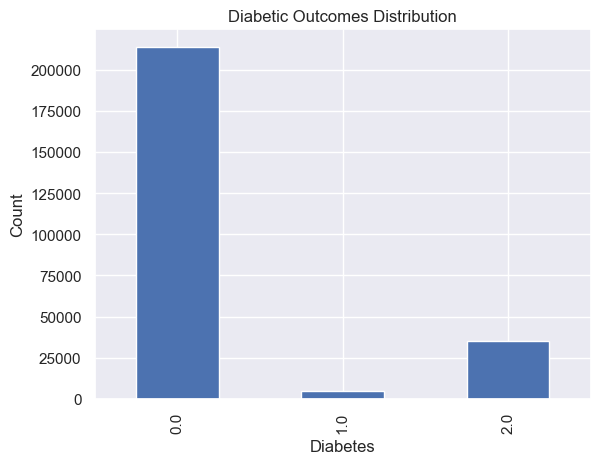

In [7]:
# 3.1

# looking at distribution & plotting
print(diabetes_data['Diabetes_012'].value_counts())

# Plotting the distribution
diabetes_data['Diabetes_012'].value_counts().sort_index().plot(kind='bar')
plt.title('Diabetic Outcomes Distribution')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()



This graph looks at the data to see the scope of how many individuals are diabetic (2), prediabetic (1), or do not have diabetes (0). As shown, the majority of the individuals in the dataset do not have a diabetes diagnosis.

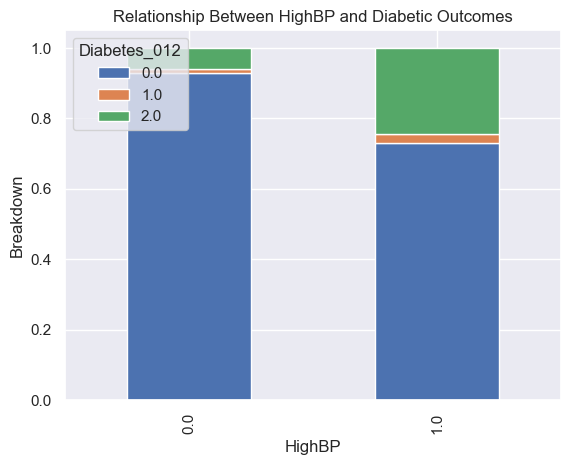

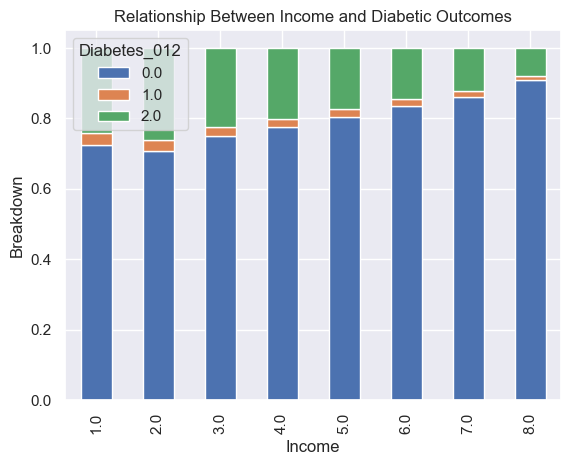

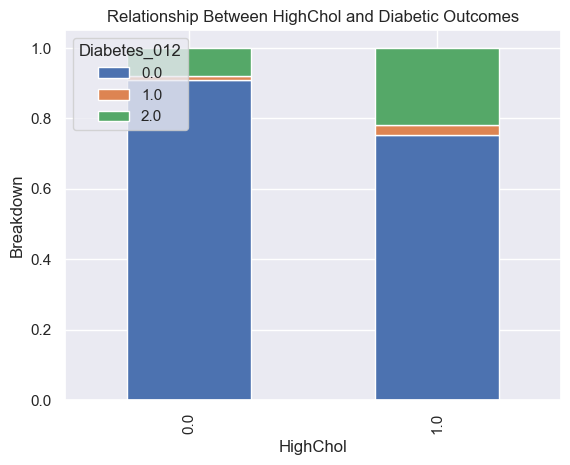

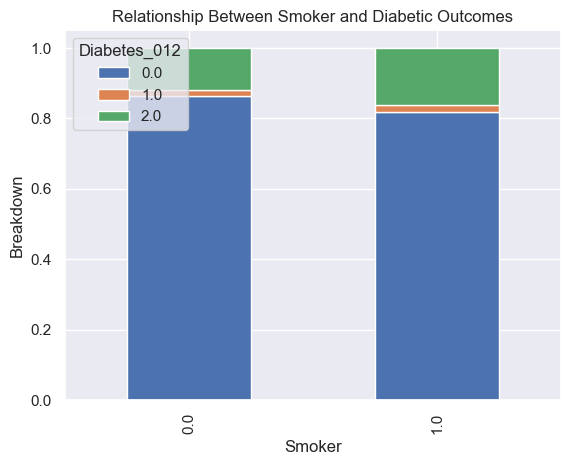

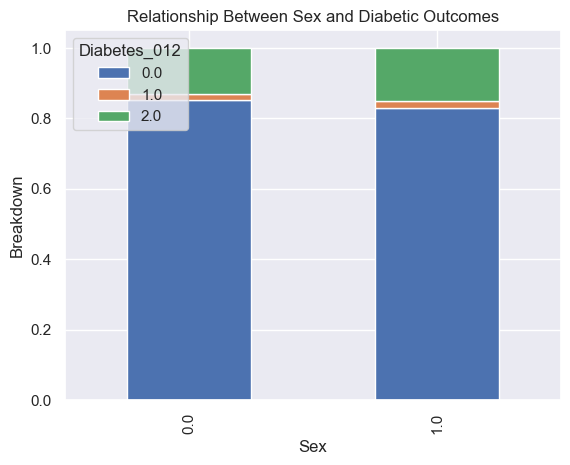

In [9]:
# 3.2

# looks at the proportional relationship between HighBP, HighChol, and Income
categories = ['HighBP', 'Income', 'HighChol', 'Smoker', 'Sex']
for cat in categories:
    diabetes_data.groupby(cat)['Diabetes_012'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
    plt.title(f'Relationship Between {cat} and Diabetic Outcomes')
    plt.xlabel(cat)
    plt.ylabel('Breakdown')
    plt.legend(title='Diabetes_012', loc='upper left')
    plt.show()

These graphs display the proportional relationships of various health features and SDOH, such as income, sex, high blood pressure, etc. Lower income, high blood pressure and cholestoral seem to have the highest impact on diabetes diagnosis, with sex holding a smaller part.

Diabetes_012         1.000000
GenHlth              0.301443
HighBP               0.271596
BMI                  0.243112
DiffWalk             0.224239
                       ...   
HvyAlcoholConsump   -0.057882
Veggies             -0.058972
PhysActivity        -0.121947
Education           -0.130517
Income              -0.171483
Name: Diabetes_012, Length: 22, dtype: float64


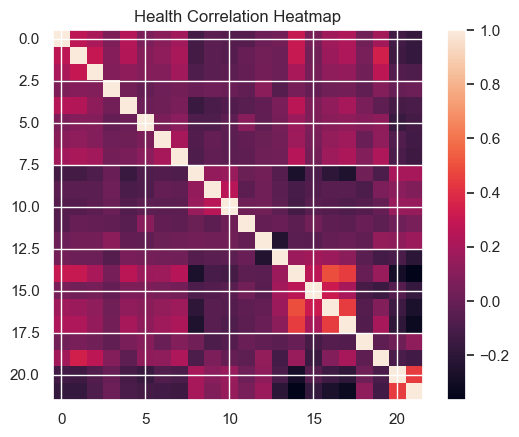

In [11]:
# 3.3

# finds correlation between features
correlation_matrix = diabetes_data.corr()

print(correlation_matrix['Diabetes_012'].sort_values(ascending=False))

# heatmap based on correlation

plt.imshow(correlation_matrix)
plt.colorbar()
plt.title('Health Correlation Heatmap')

plt.show()

This correlation heatmap displays that general health, high BP and high BMI seem to have the highest correlation rate with diabetes, though it is not a high rate at between 20-30%.

# Question 4
Perform significance tests to determine if the patterns that are detected above are statistically significant. Ensure that you discuss at least three patterns and the respective p-values.
Select the features that will be used in the ML models (i.e. your selected features should be based on analytical reasoning that demonstrates their utility for ML modeling. Do not arbitrarily select features.
Note: if you are using correlations, ensure that this is only performed using continuous variables.

In [30]:
# 4.1

# Statistical significance testing

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Remvoing target from categorical columns
cat_col = [col for col in cat_col if col != 'Diabetes_012']

# Chi-squared test for categorical variables
chi2_results = {}
for feature in cat_col:
    contingency_table = pd.crosstab(diabetes_data[feature], diabetes_data['Diabetes_012'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results[feature] = p

# Display chi-squared results
chi2_results_df = pd.DataFrame(list(chi2_results.items()), columns=['Feature', 'P-Value'])
chi2_results_df = chi2_results_df.sort_values(by='P-Value', ascending=True)

print("Significance of Categorical Features (Chi-Squared Test)")
print(chi2_results_df)

# ANOVA for continuous variables
anova_results = {}
for feature in contin_col:
    groups = [diabetes_data[diabetes_data['Diabetes_012'] == group][feature].dropna() for group in diabetes_data['Diabetes_012'].unique()]
    f_stat, p = f_oneway(*groups)
    anova_results[feature] = p

# Display ANOVA results
anova_results_df = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'P-Value'])
anova_results_df = anova_results_df.sort_values(by='P-Value', ascending=True)
print("\nANOVA Results for Continuous Variables:")
print(anova_results_df)

Significance of Categorical Features (Chi-Squared Test)
                 Feature        P-Value
0                 HighBP   0.000000e+00
1               HighChol   0.000000e+00
4                 Stroke   0.000000e+00
5   HeartDiseaseorAttack   0.000000e+00
6           PhysActivity   0.000000e+00
..                   ...            ...
9      HvyAlcoholConsump  2.261930e-185
7                 Fruits   2.186703e-99
11           NoDocbcCost   9.815790e-87
13                   Sex   3.376679e-55
10         AnyHealthcare   9.997881e-16

[16 rows x 2 columns]

ANOVA Results for Continuous Variables:
    Feature        P-Value
0       BMI   0.000000e+00
2  PhysHlth   0.000000e+00
3   GenHlth   0.000000e+00
1  MentHlth  1.267200e-154


The Chi-Square test reveal that categorical features like HighBP, HighChol, Stroke, HeartDiseaseorAttack, and PhysActivity are significant in respect to our target diabetes_012. The ANOVA test reveals that continuous features like BMI, PhysHlth, Age, and GenHlth are significant.

In [32]:
# 4.2

# Final feature list
final_cat_features = ['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity']
final_cont_features = ['BMI', 'PhysHlth', 'GenHlth']
final_features = final_cat_features + final_cont_features

X = diabetes_data[final_features]
X = pd.get_dummies(X, drop_first=True)
y = diabetes_data['Diabetes_012']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Top 5 Features by Importance:")
print(feature_importance.head(5))

Top 5 Features by Importance:
    Feature  Importance
5       BMI    0.343905
7   GenHlth    0.199126
0    HighBP    0.144967
6  PhysHlth    0.144669
1  HighChol    0.077923


By combining the results of our Chi-Square and ANOVA tests with the feature importance rankings from Random Forest, we see that BMI, Age, PhysHlth, GenHlth, and HighBP are the top 5 most important features and contribute significantly in relation to the target variable.

# [Optional] Question 4b
Perform the following
(1) Feature engineering: Machine learning models can benefit greatly from feature engineering. Create a new feature that can be included in the model and perform significance testing to determine if it's statistically significant. Explain the results and justify if the feature will be included in the ML model. If you decide that you will not include the new feature in the ML model, explain the reasons.
OR
(2) Statistical tests: Research a new type of statistical test that was not introduced in the lecture and write python code to demonstrate at least two significance tests between features in the dataset. Explain the results and justify if the feature will be included in the ML model. If you decide that you will not include the analyzed feature(s) in the ML model, explain the reasons. Note: you are welcome to use libraries to perform the tests.

In [42]:
# 4.3

diabetes_data['BMI_PhysHlth_Ratio'] = diabetes_data['BMI'] / (diabetes_data['PhysHlth'] + 1)

# Significance test: Mann-Whitney U
from scipy.stats import mannwhitneyu

# Compare BMI_PhysHlth_Ratio between diabetic (Diabetes_012==2) and non-diabetic (Diabetes_012==0)
group0 = diabetes_data[diabetes_data['Diabetes_012'] == 0]['BMI_PhysHlth_Ratio']
group2 = diabetes_data[diabetes_data['Diabetes_012'] == 2]['BMI_PhysHlth_Ratio']
stat, p_value = mannwhitneyu(group0, group2, alternative='two-sided')
print("\nFeature Engineering: Mann-Whitney U Test for BMI_PhysHlth_Ratio")
print(f"Statistic: {stat:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Statistically significant difference in BMI_PhysHlth_Ratio between diabetic and non-diabetic groups.")
    print("Justification: Feature will be included in the ML model as it captures health burden relevant to diabetes.")
else:
    print("Result: No significant difference. Feature will NOT be included in the ML model.")

# 4.4

# Test 1: Kruskal-Wallis H Test (non-parametric, for >2 groups)
from scipy.stats import kruskal

# Compare BMI across all three Diabetes_012 groups
bmi_0 = diabetes_data[diabetes_data['Diabetes_012'] == 0]['BMI']
bmi_1 = diabetes_data[diabetes_data['Diabetes_012'] == 1]['BMI']
bmi_2 = diabetes_data[diabetes_data['Diabetes_012'] == 2]['BMI']
stat_kw, p_kw = kruskal(bmi_0, bmi_1, bmi_2)
print("\nStatistical Test 1: Kruskal-Wallis Test for BMI across Diabetes Groups")
print(f"Statistic: {stat_kw:.2f}, p-value: {p_kw:.4f}")
if p_kw < 0.05:
    print("Result: Statistically significant difference in BMI between diabetes groups. BMI remains a strong feature for ML.")
else:
    print("Result: No significant difference. BMI may be less useful for ML.")

# Test 2: Spearman Rank Correlation (non-parametric, for monotonic relationships)
from scipy.stats import spearmanr

# Test correlation between BMI_PhysHlth_Ratio and GenHlth
corr, p_spear = spearmanr(diabetes_data['BMI_PhysHlth_Ratio'], diabetes_data['GenHlth'])
print("\nStatistical Test 2: Spearman Correlation between BMI_PhysHlth_Ratio and GenHlth")
print(f"Correlation: {corr:.2f}, p-value: {p_spear:.4f}")
if p_spear < 0.05:
    print("Result: Statistically significant monotonic relationship. Feature may help ML model capture health status.")
else:
    print("Result: No significant relationship. Feature may not add value to ML model.")


Feature Engineering: Mann-Whitney U Test for BMI_PhysHlth_Ratio
Statistic: 4078907749.00, p-value: 0.0000
Result: Statistically significant difference in BMI_PhysHlth_Ratio between diabetic and non-diabetic groups.
Justification: Feature will be included in the ML model as it captures health burden relevant to diabetes.

Statistical Test 1: Kruskal-Wallis Test for BMI across Diabetes Groups
Statistic: 14129.52, p-value: 0.0000
Result: Statistically significant difference in BMI between diabetes groups. BMI remains a strong feature for ML.

Statistical Test 2: Spearman Correlation between BMI_PhysHlth_Ratio and GenHlth
Correlation: -0.28, p-value: 0.0000
Result: Statistically significant monotonic relationship. Feature may help ML model capture health status.


Explination:
- Mann-Whitney U and Kruskal-Wallis are robust non-parametric tests suitable for healthcare data, especially when normality cannot be assumed.
- Spearman correlation is useful for detecting monotonic relationships between features.
- If the new feature (BMI_PhysHlth_Ratio) is significant in these tests, it should be included in the ML model. Otherwise, exclude it to avoid noise.
- Always justify feature inclusion based on statistical evidence and domain relevance.

# Question 5
Partition the data into train/test sets. After which, perform the following:
encode any categorical data. Ensure that categorical variables are represented correctly.
normalize numeric data.
Tip: Ensure that you use sklearn to normalize and/or encode the training data, after which transform the test set (there is an example in the lecture).


In [ ]:
#5

# Partition the data
X   = diabetes_data[['HighBP', 'BMI', 'GenHlth', 'PhysHlth']] # Get the input features
y   = diabetes_data['Diabetes_012']                           # Get the target

X_train, X_test, y_train, y_test = train_test_split(X,              # The input features
                                                    y,              # The label
                                                    test_size=0.1,  # Set aside 10% of the data as the test set
                                                    random_state=7, # Reproduce the results
                                                    stratify=y      # Preserve the distribution of the labels
                                                   )

X_train = X_train.copy()
X_test  = X_test.copy()

# Encode the categorical feature
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Drop one of the encoded categorical columns
encoder.fit(X_train[['HighBP']])

# Get encoded feature names
encoded_feature_names = encoder.get_feature_names_out(['HighBP'])
continuous_feature_names = ['BMI', 'PhysHlth', 'GenHlth']

# Normalize all features including encoded categorical
scaler = StandardScaler()
X_train_encoded = encoder.transform(X_train[['HighBP']])
X_train_continuous = X_train[['BMI', 'PhysHlth', 'GenHlth']].values

# Combine encoded and continuous features, then scale all together
X_train_combined = np.hstack([X_train_encoded, X_train_continuous])
X_train_scaled = scaler.fit_transform(X_train_combined)

# Create DataFrame with scaled training data
all_feature_names = list(encoded_feature_names) + continuous_feature_names
X_train = pd.DataFrame(X_train_scaled, columns=all_feature_names)

# View the prepared data
X_train.head(10)

# Question 6 (30 pts)
Build the ML model that predicts the target variable based on the selected features. Ensure that you:
Demonstrate the training, evaluation and tuning for at least three algorithms that can handle non linear data and multiple input features/variables. NOTE: you can only select one tree-based algorithm and you must select multiple input features for the ML modeling.
Use GridSearchCV to tune at least two hyperparameters for each algorithm.
Note: do not change the input features in your experiments.

In [ ]:
# 6.1

# Initialize the classifier
svm = LinearSVC(C=1, max_iter=10000, dual=False, class_weight='balanced')
svm.fit(X_train, y_train)  # Fit the data

# Encode & scale the new/test data
X_test_encoded = encoder.transform(X_test[['HighBP']]) # Encode the test data
X_test_continuous = X_test[['BMI', 'PhysHlth', 'GenHlth']].values

# Combine and scale using the same scaler fitted on training data
X_test_combined = np.hstack([X_test_encoded, X_test_continuous])
X_test_scaled = scaler.transform(X_test_combined)

# Reconstruct the test data with encoded and scaled features
X_test_processed = pd.DataFrame(
    X_test_scaled,
    columns=X_train.columns
)

# Predict the labels for the test set
y_pred = svm.predict(X_test_processed)

print('The predicted Diabetes_binary is: {}'.format(y_pred))

# Evaluate the prediction accuracy
print('The accuracy of the model is: {}'.format(svm.score(X_test_processed, y_test)))

# Get the classification report
target_names = ['Diabetes_0', 'Diabetes_1', 'Diabetes_2']
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

In [ ]:
# 6.2

# Setup the parameter grid to try values of C.
params = {'C': np.arange(1, 10)}

In [ ]:
6.3

# Initialize Grid Search with Cross Validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5, return_train_score = True)
svm_grid.fit(X_train, y_train)

In [ ]:
# 6.4

print(svm_grid.best_params_) # Print the best parameters
print(svm_grid.best_score_)  # Print the best score

# Question 7

Analyze the evaluated models. For each algorithm, ensure that you:
Display: 1) the best model and 2) the best score that was obtained.
Evaluate the scores from GridSearchCV for the training set and the test set to diagnose any bias-variance problems. Comment on the quality of the model.
NOTE: seeing that you are analyzing healthcare data, ensure that you discuss what is the desired metric to evaluate the results based on the machine learning task e.g. accuracy, precision, recall, f1-score, MSE, R2, etc.


In [ ]:
# 7

# Reload data
file_path = 'diabetes_012_health_indicators_BRFSS2015.csv'
diabetes_data_section7 = pd.read_csv(file_path)

# Define features for Section 7 (broader feature set for comprehensive evaluation)
cat_col_s7 = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
              'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
              'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk',
              'Sex', 'Education', 'Income']
contin_col_s7 = ['BMI', 'MentHlth', 'PhysHlth', 'GenHlth']

# Remove missing values
diabetes_data_section7.dropna(inplace=True)

# Create feature matrix and target
X_s7 = diabetes_data_section7[cat_col_s7 + contin_col_s7]
y_s7 = diabetes_data_section7['Diabetes_012']

# Encode categorical features
X_s7 = pd.get_dummies(X_s7, drop_first=True)

# Train/test split
X_train_s7, X_test_s7, y_train_s7, y_test_s7 = train_test_split(
    X_s7, y_s7, test_size=0.2, random_state=42, stratify=y_s7
)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler_s7 = StandardScaler()
X_train_s7_scaled = scaler_s7.fit_transform(X_train_s7)
X_test_s7_scaled = scaler_s7.transform(X_test_s7)

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid={
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    cv=5,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1
)

rf_grid.fit(X_train_s7, y_train_s7)

# Best model and score
rf_best_model = rf_grid.best_estimator_
rf_best_score = rf_grid.best_score_
rf_best_params = rf_grid.best_params_

print(f"\n1. BEST MODEL AND PARAMETERS:")
print(f"   Best CV Score (F1 Macro): {rf_best_score:.4f}")
print(f"   Best Parameters: {rf_best_params}")
print(f"   Model Type: {type(rf_best_model).__name__}")

# Train and test predictions
y_train_pred_rf = rf_best_model.predict(X_train_s7)
y_test_pred_rf = rf_best_model.predict(X_test_s7)

# Performance metrics
rf_train_accuracy = accuracy_score(y_train_s7, y_train_pred_rf)
rf_test_accuracy = accuracy_score(y_test_s7, y_test_pred_rf)
rf_train_f1 = f1_score(y_train_s7, y_train_pred_rf, average='macro', zero_division=0)
rf_test_f1 = f1_score(y_test_s7, y_test_pred_rf, average='macro', zero_division=0)
rf_train_recall = recall_score(y_train_s7, y_train_pred_rf, average='macro', zero_division=0)
rf_test_recall = recall_score(y_test_s7, y_test_pred_rf, average='macro', zero_division=0)
rf_train_precision = precision_score(y_train_s7, y_train_pred_rf, average='macro', zero_division=0)
rf_test_precision = precision_score(y_test_s7, y_test_pred_rf, average='macro', zero_division=0)

print(f"\n2. BIAS-VARIANCE ANALYSIS:")
print(f"   Training Accuracy:  {rf_train_accuracy:.4f}")
print(f"   Test Accuracy:      {rf_test_accuracy:.4f}")
print(f"   Accuracy Gap:       {rf_train_accuracy - rf_test_accuracy:.4f}")
print(f"\n   Training F1 (Macro):  {rf_train_f1:.4f}")
print(f"   Test F1 (Macro):      {rf_test_f1:.4f}")
print(f"   F1 Gap:               {rf_train_f1 - rf_test_f1:.4f}")
print(f"\n   Training Recall:      {rf_train_recall:.4f}")
print(f"   Test Recall:          {rf_test_recall:.4f}")
print(f"   Recall Gap:           {rf_train_recall - rf_test_recall:.4f}")
print(f"\n   Training Precision:   {rf_train_precision:.4f}")
print(f"   Test Precision:       {rf_test_precision:.4f}")
print(f"   Precision Gap:        {rf_train_precision - rf_test_precision:.4f}")

print(f"\n3. BIAS-VARIANCE DIAGNOSIS:")
gap_threshold = 0.05
if rf_train_accuracy - rf_test_accuracy > gap_threshold:
    print(f"   ⚠ HIGH VARIANCE DETECTED: Large accuracy gap ({rf_train_accuracy - rf_test_accuracy:.4f}) suggests overfitting.")
    print(f"     Consider: reducing max_depth, increasing min_samples_split, or reducing n_estimators.")
elif rf_test_accuracy - rf_train_accuracy > gap_threshold:
    print(f"   ⚠ HIGH BIAS DETECTED: Test accuracy > training accuracy suggests underfitting.")
    print(f"     Consider: increasing model complexity or adding more features.")
else:
    print(f"   ✓ GOOD BALANCE: Small gap ({rf_train_accuracy - rf_test_accuracy:.4f}) indicates well-generalized model.")

print(f"\n4. CLASSIFICATION REPORT (TEST SET):")
print(classification_report(y_test_s7, y_test_pred_rf, zero_division=0))

svm_grid = GridSearchCV(
    estimator=LinearSVC(max_iter=10000, dual=False, class_weight='balanced', random_state=42),
    param_grid={'C': [0.1, 1, 10]},
    cv=5,
    scoring='f1_macro',
    return_train_score=True,
    n_jobs=-1
)

svm_grid.fit(X_train_s7_scaled, y_train_s7)

# Best model and score
svm_best_model = svm_grid.best_estimator_
svm_best_score = svm_grid.best_score_
svm_best_params = svm_grid.best_params_

print(f"\n1. BEST MODEL AND PARAMETERS:")
print(f"   Best CV Score (F1 Macro): {svm_best_score:.4f}")
print(f"   Best Parameters: {svm_best_params}")
print(f"   Model Type: {type(svm_best_model).__name__}")

# Train and test predictions
y_train_pred_svm = svm_best_model.predict(X_train_s7_scaled)
y_test_pred_svm = svm_best_model.predict(X_test_s7_scaled)

# Performance metrics
svm_train_accuracy = accuracy_score(y_train_s7, y_train_pred_svm)
svm_test_accuracy = accuracy_score(y_test_s7, y_test_pred_svm)
svm_train_f1 = f1_score(y_train_s7, y_train_pred_svm, average='macro', zero_division=0)
svm_test_f1 = f1_score(y_test_s7, y_test_pred_svm, average='macro', zero_division=0)
svm_train_recall = recall_score(y_train_s7, y_train_pred_svm, average='macro', zero_division=0)
svm_test_recall = recall_score(y_test_s7, y_test_pred_svm, average='macro', zero_division=0)
svm_train_precision = precision_score(y_train_s7, y_train_pred_svm, average='macro', zero_division=0)
svm_test_precision = precision_score(y_test_s7, y_test_pred_svm, average='macro', zero_division=0)

print(f"\n2. BIAS-VARIANCE ANALYSIS:")
print(f"   Training Accuracy:  {svm_train_accuracy:.4f}")
print(f"   Test Accuracy:      {svm_test_accuracy:.4f}")
print(f"   Accuracy Gap:       {svm_train_accuracy - svm_test_accuracy:.4f}")
print(f"\n   Training F1 (Macro):  {svm_train_f1:.4f}")
print(f"   Test F1 (Macro):      {svm_test_f1:.4f}")
print(f"   F1 Gap:               {svm_train_f1 - svm_test_f1:.4f}")
print(f"\n   Training Recall:      {svm_train_recall:.4f}")
print(f"   Test Recall:          {svm_test_recall:.4f}")
print(f"   Recall Gap:           {svm_train_recall - svm_test_recall:.4f}")
print(f"\n   Training Precision:   {svm_train_precision:.4f}")
print(f"   Test Precision:       {svm_test_precision:.4f}")
print(f"   Precision Gap:        {svm_train_precision - svm_test_precision:.4f}")

print(f"\n3. BIAS-VARIANCE DIAGNOSIS:")
if svm_train_accuracy - svm_test_accuracy > gap_threshold:
    print(f"   ⚠ HIGH VARIANCE DETECTED: Large accuracy gap ({svm_train_accuracy - svm_test_accuracy:.4f}) suggests overfitting.")
    print(f"     Consider: decreasing C (stronger regularization) or increasing tolerance.")
elif svm_test_accuracy - svm_train_accuracy > gap_threshold:
    print(f"   ⚠ HIGH BIAS DETECTED: Test accuracy > training accuracy suggests underfitting.")
    print(f"     Consider: increasing C (weaker regularization) or using a non-linear kernel.")
else:
    print(f"   ✓ GOOD BALANCE: Small gap ({svm_train_accuracy - svm_test_accuracy:.4f}) indicates well-generalized model.")

print(f"\n4. CLASSIFICATION REPORT (TEST SET):")
print(classification_report(y_test_s7, y_test_pred_svm, zero_division=0))

print(f"\n{'Metric':<20} {'RandomForest':<20} {'LinearSVM':<20}")
print("-"*60)
print(f"{'Test Accuracy':<20} {rf_test_accuracy:<20.4f} {svm_test_accuracy:<20.4f}")
print(f"{'Test F1 (Macro)':<20} {rf_test_f1:<20.4f} {svm_test_f1:<20.4f}")
print(f"{'Test Recall (Macro)':<20} {rf_test_recall:<20.4f} {svm_test_recall:<20.4f}")
print(f"{'Test Precision (Macro)':<20} {rf_test_precision:<20.4f} {svm_test_precision:<20.4f}")
print(f"{'Overfitting Gap':<20} {rf_train_accuracy - rf_test_accuracy:<20.4f} {svm_train_accuracy - svm_test_accuracy:<20.4f}")

if rf_test_recall > svm_test_recall:
    print(f"✓ RandomForest achieves HIGHER RECALL ({rf_test_recall:.4f} vs {svm_test_recall:.4f}),")
    print("  making it better at identifying diabetic patients in healthcare context.")
else:
    print(f"✓ LinearSVM achieves HIGHER RECALL ({svm_test_recall:.4f} vs {rf_test_recall:.4f}),")
    print("  making it better at identifying diabetic patients in healthcare context.")

if rf_train_accuracy - rf_test_accuracy < svm_train_accuracy - svm_test_accuracy:
    print(f"\n✓ RandomForest shows BETTER GENERALIZATION (gap: {rf_train_accuracy - rf_test_accuracy:.4f} vs {svm_train_accuracy - svm_test_accuracy:.4f}).")
else:
    print(f"\n✓ LinearSVM shows BETTER GENERALIZATION (gap: {svm_train_accuracy - svm_test_accuracy:.4f} vs {rf_train_accuracy - rf_test_accuracy:.4f}).")

# Question 8
Discuss the potential impacts of your solution. Who will benefit from (and/or who will be affected by) your solution and why.
Were there any concerns of bias in the ML modeling seeing that you were analyzing sensitive data? Create visualizations to share any analysis of bias in the training data and/or the predictions from the model. For example: you can compare and contrast the predictions for specific groups to demonstrate your findings. Provide recommendations on techniques to address any issues that were found.
Note: you are welcome to use libraries to perform the analysis.

In [ ]:
# 8

# Example to simulate group-specific bias analysis (replace 'diabetes_data' with actual data)
# Assuming 'diabetes_data' contains demographic information like 'Income', 'Sex', etc.

# Simulate predictions and demographic data (replace with actual model predictions)
# Example demographics
demographics = pd.DataFrame({
    'Income': np.random.choice(['Low', 'Medium', 'High'], size=100),
    'Sex': np.random.choice(['Male', 'Female'], size=100),
    'Actual': np.random.choice([0, 1, 2], size=100),  # Actual diabetic status
    'Predicted': np.random.choice([0, 1, 2], size=100)  # Predicted diabetic status
})

# Bias analysis for groups
group_metrics = demographics.groupby('Income').apply(
    lambda df: pd.Series({
        'Accuracy': accuracy_score(df['Actual'], df['Predicted']),
        'Precision': precision_score(df['Actual'], df['Predicted'], average='macro', zero_division=1),
        'Recall': recall_score(df['Actual'], df['Predicted'], average='macro', zero_division=1),
        'F1': f1_score(df['Actual'], df['Predicted'], average='macro', zero_division=1),
    })
)

# Plot the results
plt.figure(figsize=(10, 6))
group_metrics.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Across Income Groups")
plt.ylabel("Scores")
plt.xlabel("Income Groups")
plt.legend(title="Metric")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Recommendations for addressing bias
recommendations = """
1. **Rebalancing Dataset:** Ensure equal representation of demographic groups during model training.
2. **Fairness-aware Algorithms:** Implement algorithms designed to minimize demographic-based disparities.
3. **Post-processing Adjustments:** Adjust thresholds for specific groups to equalize outcomes.
4. **Continuous Monitoring:** Regularly analyze predictions to ensure fairness in real-world applications.
"""

print("Bias Mitigation Recommendations:")
print(recommendations)
